In [14]:
from astropy.io import fits
#from astropy.modeling import models, fitting
from astropy.utils.exceptions import AstropyUserWarning
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import numpy as np
import lmfit
from lmfit.models import GaussianModel 
from lmfit.lineshapes import gaussian2d
from scipy.interpolate import griddata
from scipy import optimize


In [2]:
#data_path = Path("C:/Users/ajo5182/Documents/astro/point spread funtion and localization accuracy/image_reconstruction.fits")
data_path = Path("c:/Users/ajo5182/Documents/astro/y2024-12-09/BC001_Al_FF_243K_HORI_0_0/Analysis/imaging_analysis_20241213/image_reconstruction.fits.gz")

d = fits.open(data_path) # open fits file

data = d[0].data # data contents of the fits file
shape =  data.shape
imPixelSizeX = 0.0149 # pixel size degrees
imPixelSizeY = 0.0149 # pixel size degrees

#change y lab to xlab, and vice versa

ylab = imPixelSizeY * np.linspace((shape[0]-1)/-2,(shape[0]-1)/2, shape[0]) # create array from -23 deg to 23 deg, centered on zero
xlab = imPixelSizeX * np.linspace((shape[1]-1)/-2,(shape[1]-1)/2, shape[1]) # create array from -41 deg to 41 deg, centered on zero


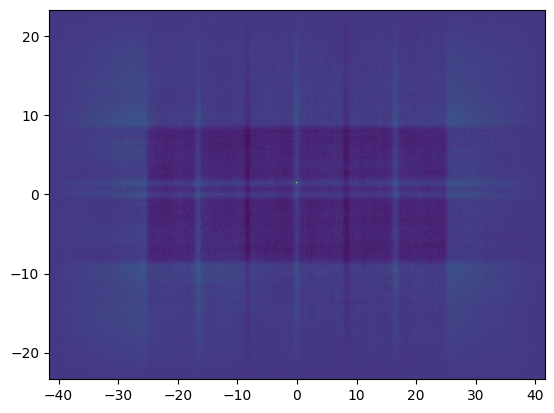

In [3]:
fig,ax =  plt.subplots()
ax.pcolormesh(xlab, ylab, data)

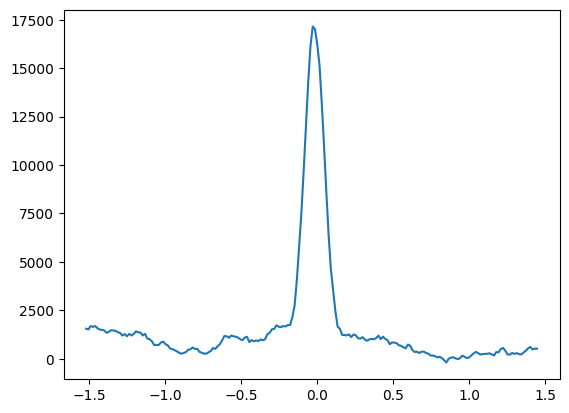

In [4]:
peak = np.max(data)
peak_loc = np.unravel_index(np.argmax(data),data.shape)
window = 100
data_windowed = data[peak_loc[0]-window:peak_loc[0]+window,peak_loc[1]-window:peak_loc[1]+window]

xfit_xcut = 1* xlab[peak_loc[1]-window:peak_loc[1]+window]
yfit_xcut = data[peak_loc[0]-window:peak_loc[0]+window,peak_loc[1]]

plt.plot(xfit_xcut,yfit_xcut)
#plt.plot(xlab[peak_loc[0]-window:peak_loc[0]+window], data[peak_loc[0]-window:peak_loc[0]+window,peak_loc[1]])
#plt.plot(data)

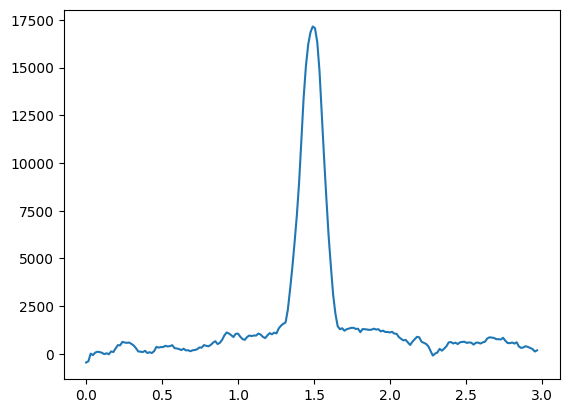

In [5]:
xfit_ycut =ylab[peak_loc[0]-window:peak_loc[0]+window]
yfit_ycut = data[peak_loc[0],peak_loc[1]-window:peak_loc[1]+window]

plt.plot(xfit_ycut,yfit_ycut)


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 200
    # variables        = 3
    chi-square         = 1.4273e+08
    reduced chi-square = 724540.554
    Akaike info crit   = 2701.63588
    Bayesian info crit = 2711.53083
    R-squared          = 0.92692148
[[Variables]]
    amplitude:  2946.68660 +/- 63.2672511 (2.15%) (init = 3876.986)
    center:    -0.01901764 +/- 0.00172869 (9.09%) (init = -0.0149)
    sigma:      0.06972724 +/- 0.00172871 (2.48%) (init = 0.0745)
    fwhm:       0.16419510 +/- 0.00407080 (2.48%) == '2.3548200*sigma'
    height:     16859.3781 +/- 361.981938 (2.15%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = +0.5774


c:\Users\ajo5182\AppData\Local\miniconda3\envs\xhcd\Lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


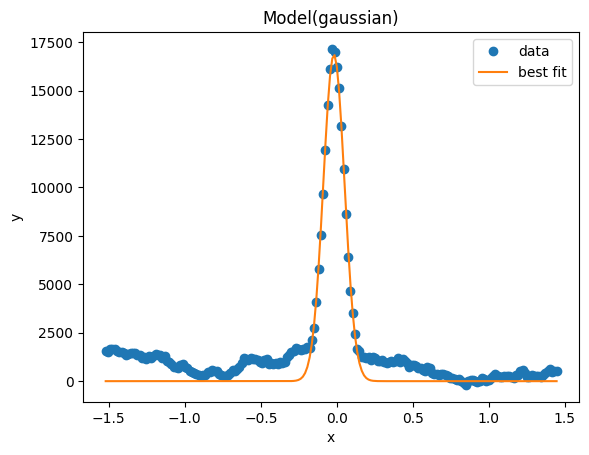

In [6]:
Xmodel  = GaussianModel()
params = Xmodel.guess(yfit_xcut, xfit_xcut)
Xresult = Xmodel.fit(yfit_xcut, params,x = xfit_xcut)
Xresult.plot_fit()
print(Xresult.fit_report())

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude      3386     -inf      inf    53.27     True     None     None
center        1.486     -inf      inf 0.001422     True     None     None
fwhm         0.1843     -inf      inf 0.003348    False 2.3548200*sigma     None
height     1.726e+04     -inf      inf    271.5    False 0.3989423*amplitude/max(1e-15, sigma)     None
sigma       0.07828        0      inf 0.001422     True     None     None


<Parameter 'fwhm', value=np.float64(0.1843239846242024) +/- 0.00335, bounds=[-inf:inf], expr='2.3548200*sigma'>

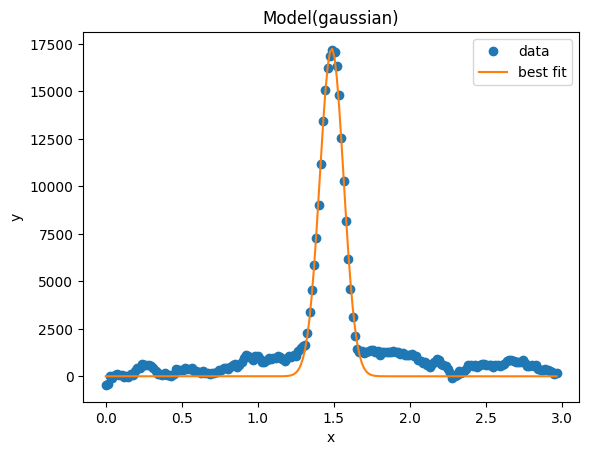

In [7]:
Ymodel  = GaussianModel()
params = Xmodel.guess(yfit_ycut, xfit_ycut)
Yresult = Xmodel.fit(yfit_ycut, params,x = xfit_ycut)
Yresult.plot_fit()
#print(Yresult.fit_report())
Yresult.params.pretty_print()
Yresult.params["fwhm"]

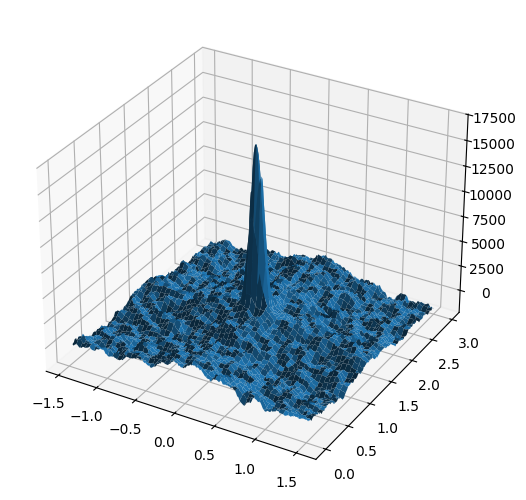

In [19]:
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
X,Y = np.meshgrid(-1* xlab[peak_loc[1]-window:peak_loc[1]+window],ylab[peak_loc[0]-window:peak_loc[0]+window])
ax.plot_surface(X,Y, data_windowed)

#params2d = fitgaussian(data_windowed)

In [23]:
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-y)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p


param2d = fitgaussian(data_windowed)

C:\Users\ajo5182\AppData\Local\Temp\ipykernel_48720\3790695933.py:17: RuntimeWarning: invalid value encountered in sqrt
  width_x = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())


IndexError: index 245 is out of bounds for axis 0 with size 200

In [22]:
test= data_windowed(xfit_xcut, xfit_ycut)

TypeError: 'numpy.ndarray' object is not callable